In [1]:
from sklearn.datasets import fetch_20newsgroups
 
# Step 1: Load dataset (you can choose categories or fetch all)
newsgroups = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
 

In [2]:
newsgroups

{'data': ['I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.',
  "A fair number of brave souls who upgraded their SI clock oscillator have\nshared their experiences for this poll. Please send a brief message detailing\nyour experiences with the procedure. Top speed attained, CPU rated speed,\nadd on cards and adapters, heat sinks, hour of usage per day, floppy disk\nfunctionality with 800 and 1.4 m floppies are especially requested.\n\nI will be summarizing in the next two days, so please add to the network\nknowledge base if you have done the clock upgrade and 

In [3]:
print(type(newsgroups))

<class 'sklearn.utils._bunch.Bunch'>


In [5]:
# import pandas as pd
# df = pd.DataFrame(newsgroups)
# df

In [6]:
# The actual text data
texts = newsgroups.data

# The target labels (numbers representing categories)
labels = newsgroups.target

# The names of the categories
category_names = newsgroups.target_names

In [7]:
print(f"Number of documents: {len(texts)}")
print(f"Number of categories: {len(category_names)}")
print(f"Sample category: {category_names[0]}")
print(f"First document preview: {texts[0][:200]}...")

Number of documents: 11314
Number of categories: 20
Sample category: alt.atheism
First document preview: I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were ...


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Create CountVectorizer (simpler than TF-IDF for LDA)
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, 
                                 max_features=1000,
                                 stop_words='english')

# Vectorize the text data
doc_term_matrix = count_vectorizer.fit_transform(texts)

In [9]:
# Set up LDA model
num_topics = 3  # Since we have 3 categories
lda_model = LatentDirichletAllocation(n_components=num_topics, 
                                    random_state=42)

# Fit the model
lda_model.fit(doc_term_matrix)

,n_components,3
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [10]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                           for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print_top_words(lda_model, count_vectorizer.get_feature_names_out(), 10)

Topic #0: ax max g9v b8f a86 pl 145 1d9 34u 1t
Topic #1: people don just like think know time good god does
Topic #2: edu use file 10 com program windows information available 00


In [11]:
# Transform documents to topic distributions
topic_distributions = lda_model.transform(doc_term_matrix)

# Get the dominant topic for each document
dominant_topics = topic_distributions.argmax(axis=1)

In [12]:
from sklearn.metrics import adjusted_rand_score, homogeneity_score

# Compare with original labels
print(f"Adjusted Rand Index: {adjusted_rand_score(labels, dominant_topics)}")
print(f"Homogeneity Score: {homogeneity_score(labels, dominant_topics)}")

Adjusted Rand Index: 0.03454799279471556
Homogeneity Score: 0.07834968929514442


In [13]:

perplexity = lda_model.perplexity(doc_term_matrix)
print(f"Model Perplexity: {perplexity:.2f}")

Model Perplexity: 315.32


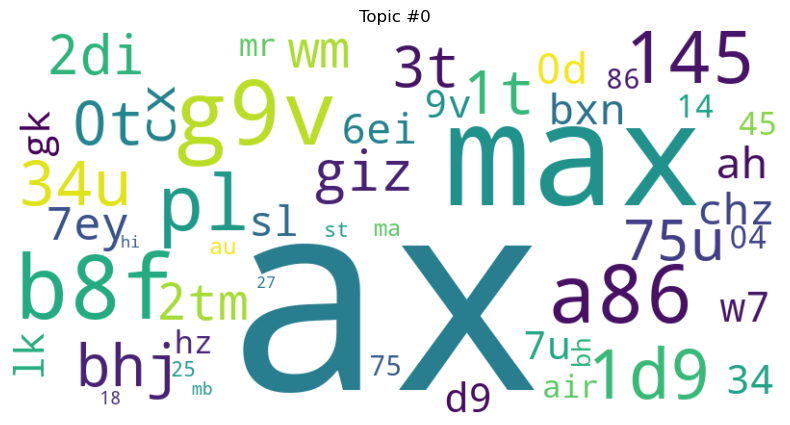

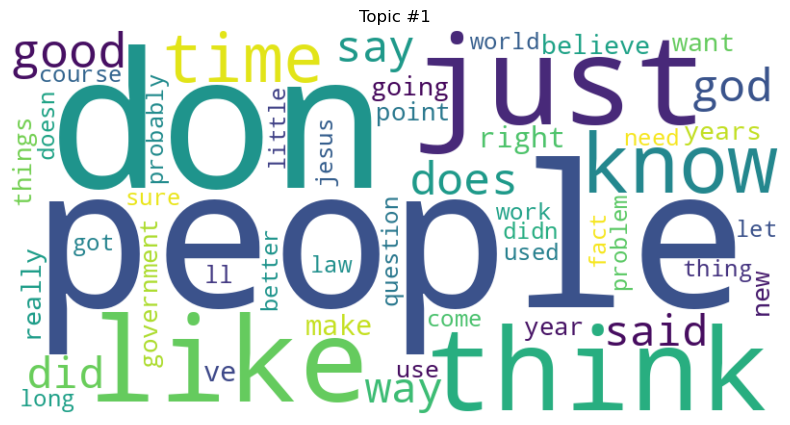

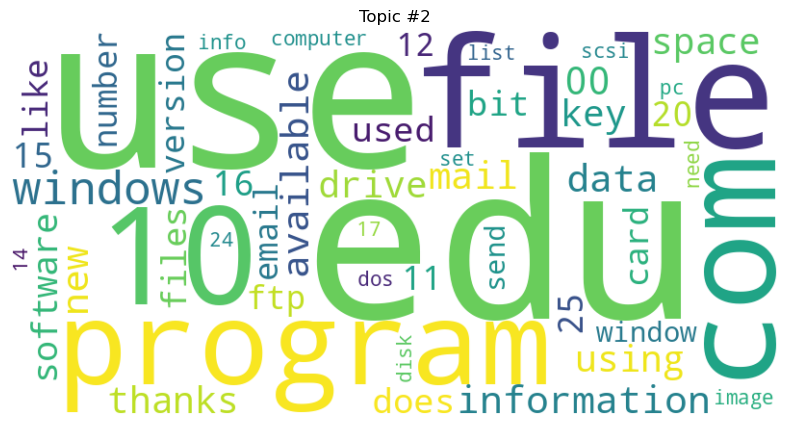

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_word_cloud(lda_model, feature_names, topic_idx):
    # Get the top words and their weights for the topic
    topic_weights = lda_model.components_[topic_idx]
    word_weights = {feature_names[i]: topic_weights[i] for i in topic_weights.argsort()[:-50 - 1:-1]}
    
    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color='white')
    wc.generate_from_frequencies(word_weights)
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Topic #{topic_idx}')
    plt.show()

# Install wordcloud if needed: pip install wordcloud
# Then visualize each topic:
for i in range(num_topics):
    plot_word_cloud(lda_model, count_vectorizer.get_feature_names_out(), i)

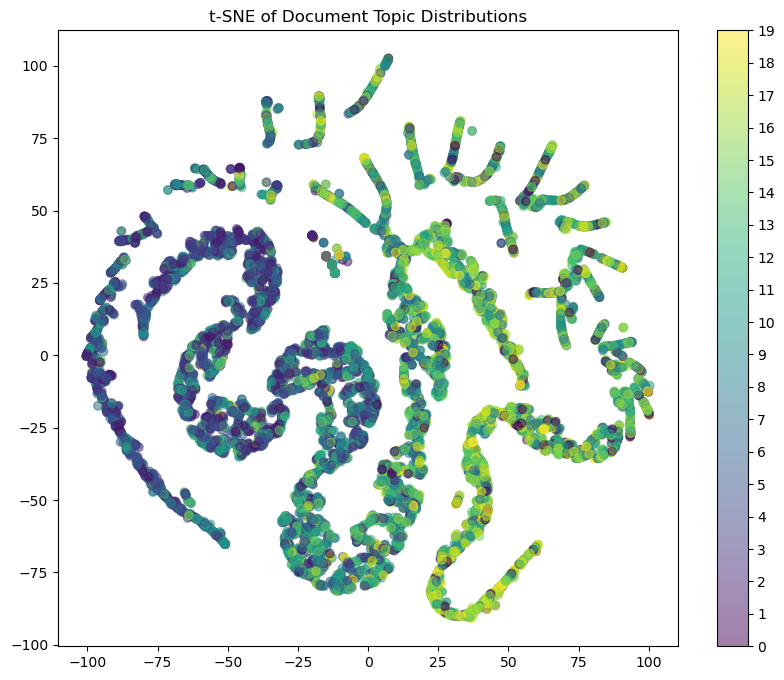

In [16]:
from sklearn.manifold import TSNE

# Get document topic distributions
doc_topics = lda_model.transform(doc_term_matrix)

# Reduce to 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42)
doc_topics_2d = tsne.fit_transform(doc_topics)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(doc_topics_2d[:, 0], doc_topics_2d[:, 1], 
           c=newsgroups.target, cmap='viridis', alpha=0.5)
plt.colorbar(ticks=range(len(newsgroups.target_names)))
plt.title("t-SNE of Document Topic Distributions")
plt.show()

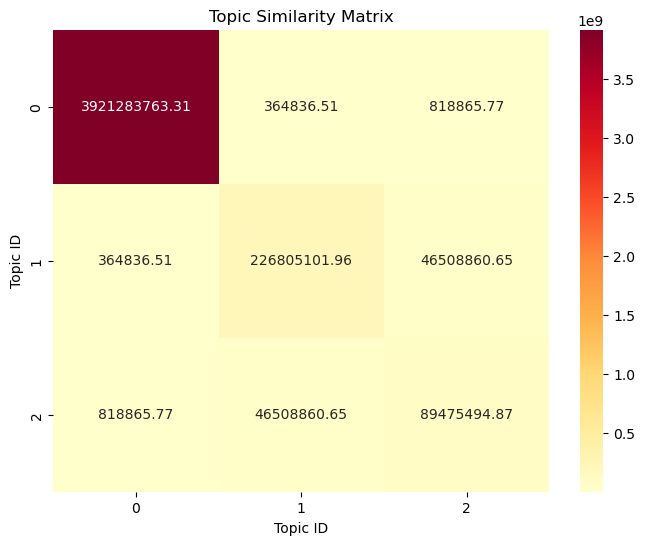

In [ ]:
import seaborn as sns
import numpy as np

# Compute topic similarity matrix
topic_similarity = np.dot(lda_model.components_, lda_model.components_.T)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(topic_similarity, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Topic Similarity Matrix")
plt.xlabel("Topic ID")
plt.ylabel("Topic ID")
plt.show()

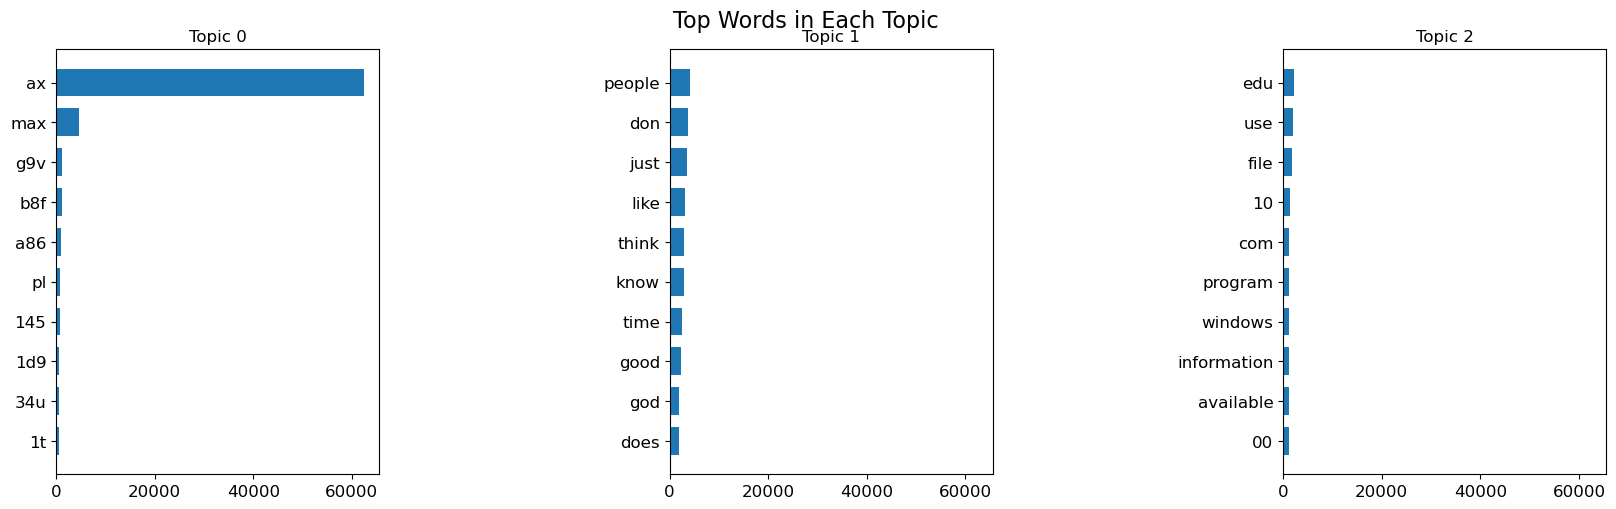

In [18]:
def plot_top_words(lda_model, feature_names, n_top_words=10):
    fig, axes = plt.subplots(1, num_topics, figsize=(20, 5), sharex=True)
    
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        weights = topic[top_words_idx]
        
        ax = axes[topic_idx]
        ax.barh(top_words, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx}')
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.suptitle('Top Words in Each Topic', fontsize=16)
    plt.show()

plot_top_words(lda_model, count_vectorizer.get_feature_names_out())

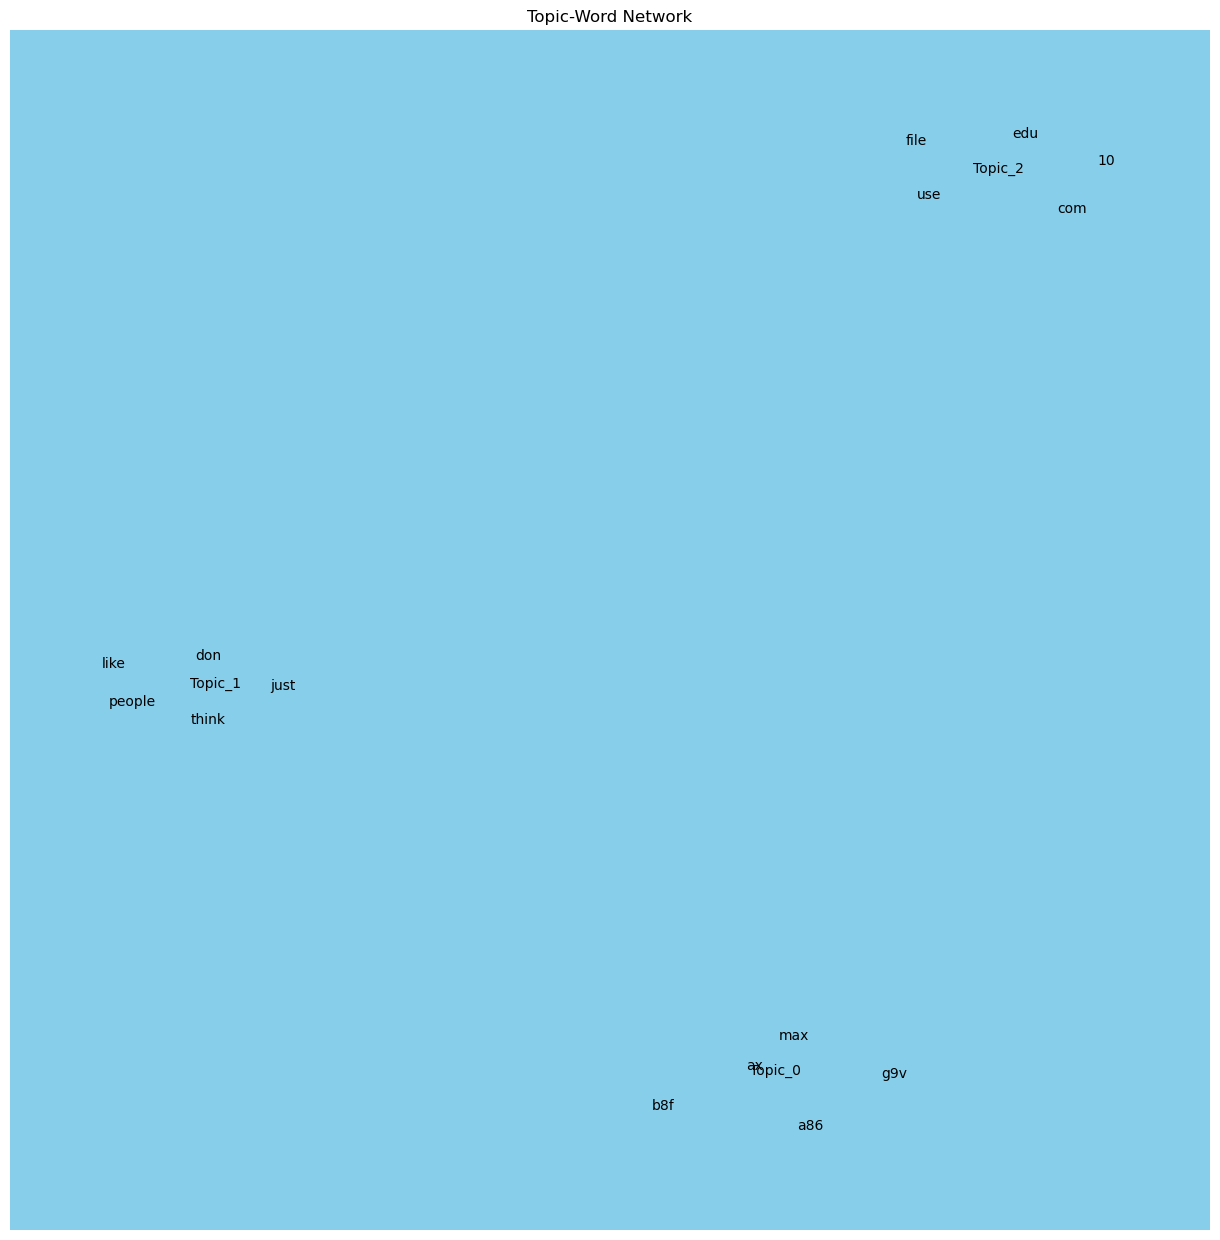

In [19]:
import networkx as nx

def plot_topic_network(lda_model, feature_names, n_top_words=5):
    G = nx.Graph()
    
    # Add topic nodes
    for topic_idx in range(lda_model.n_components):
        G.add_node(f"Topic_{topic_idx}", type='topic', size=1000)
        
        # Add top words and connections
        top_words_idx = lda_model.components_[topic_idx].argsort()[:-n_top_words - 1:-1]
        for i in top_words_idx:
            word = feature_names[i]
            weight = lda_model.components_[topic_idx][i]
            G.add_node(word, type='word', size=weight*500)
            G.add_edge(f"Topic_{topic_idx}", word, weight=weight*10)
    
    # Draw the graph
    pos = nx.spring_layout(G, k=0.5)
    node_colors = ['red' if G.nodes[n]['type'] == 'topic' else 'skyblue' for n in G.nodes]
    node_sizes = [G.nodes[n]['size'] for n in G.nodes]
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, 
           node_color=node_colors, 
           node_size=node_sizes,
           font_size=10, 
           edge_color='gray', 
           width=[d['weight']*0.5 for u,v,d in G.edges(data=True)])
    plt.title("Topic-Word Network")
    plt.show()

plot_topic_network(lda_model, count_vectorizer.get_feature_names_out())

In [20]:
import plotly.express as px

# Prepare data for Plotly
topics_data = []
for topic_idx, topic in enumerate(lda_model.components_):
    for i in topic.argsort()[-10:]:  # Top 10 words
        topics_data.append({
            'Topic': f'Topic {topic_idx}',
            'Word': count_vectorizer.get_feature_names_out()[i],
            'Weight': topic[i]
        })

df = pd.DataFrame(topics_data)

# Create interactive bar chart
fig = px.bar(df, x='Weight', y='Word', orientation='h',
             color='Topic', facet_col='Topic',
             facet_col_wrap=2, height=1000)
fig.update_yaxes(matches=None)
fig.show()

In [ ]:
# import pyLDAvis
# import pyLDAvis.sklearn

# # Prepare the visualization
# panel = pyLDAvis.sklearn.prepare(lda_model, doc_term_matrix, count_vectorizer)

# # Display (in Jupyter notebook)
# pyLDAvis.display(panel)

# # To save as HTML
# pyLDAvis.save_html(panel, 'lda_visualization.html')